# Installations and Imports

In [1]:
!pip install pennylane --upgrade

from IPython.display import clear_output
clear_output(wait=False)

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Importing data files

### npy data files created by the quanvolutional notebook has been imported here. 

In [3]:
x_train_final = np.load("x_train_final.npy")
y_train = np.load("y_train.npy")

x_test_final = np.load("x_test_final.npy")
y_test = np.load("y_test.npy")

In [4]:
x_train_final.shape, y_train.shape, x_test_final.shape, y_test.shape

((250, 256), (250,), (65, 256), (65,))

## Reducing 256 features of each image to 4 using TruncatedSVD because it is not feasible to encode 256 features for each image in a quantum circuit. 

In [5]:
tsvd = TruncatedSVD(n_components=4)
x_train_final = tsvd.fit_transform(x_train_final)
x_test_final = tsvd.fit_transform(x_test_final)


# np.random.seed(0)
# tsne = TSNE(n_components=2)
# train_data_features_reduced = tsne.fit_transform(X_SVD)

In [6]:
x_train_final.shape, x_test_final.shape

((250, 4), (65, 4))

# Classifier Model description

### In the dataset we have three classses - Covid19, Viral Penumonia and Normal person. 

### Our approach is to divide the classfier in two different models. First model will classify between the classes 'Normal Person' and 'Covid19/Viral Pneumonia'. Second model will classify between the classes 'Covid' and 'Viral Penumonia' 

### First model here is denoted by Model-1 and second one by Model-2. 

# Required functions for classifier model-1

In [7]:
def statepreparation_1(a):


    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.RZ(a[0], wires=0)
    qml.RZ(a[1], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(a[0]*a[1], wires=1)
    qml.CNOT(wires=[0,1])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.RZ(a[2], wires=0)
    qml.RZ(a[3], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(a[2]*a[3], wires=1)
    qml.CNOT(wires=[0,1])


    

In [8]:
def layer_1(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    # qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    
    qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[0, 2])
    # qml.CNOT(wires=[1, 2])

In [9]:
dev_1 = qml.device("default.qubit", wires=2)
@qml.qnode(dev_1)
def circuit_1(weights, x=None):
    
    # Feature mapping
    statepreparation_1(x)
    # variational classifier
    for w in weights:
        layer_1(w)
    
    return qml.expval(qml.PauliZ(1))

In [10]:
def classifier_training_1(params, x=None, y=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_1(weights, x=x) + bias
    return (out_probs-y)**2


In [11]:
def classifier_prediction_1(params, x=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_1(weights, x=x) + bias

    
    if(out_probs>0):
        return 1
    else:
        return -1

In [12]:
def circuit_output_test(params, x=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit(weights, x=x) + bias

    return out_probs


In [13]:
 def cost_1(params, X, Y):

    y_pred = np.array([classifier_training_1(params, x=X[i], y=Y[i]) for i in range(len(Y))])

    cost = np.sum(y_pred) / len(Y)
    return cost

In [14]:
def accuracy_1(params, x_train, y_train, iter):

    y_pred_train = np.array([classifier_prediction_1(params, x=x) for x in x_train])
    acc_train = np.sum(y_pred_train==y_train) / len(y_train)

    print("Iter=> {}   train_cost=> {}   train_acc=> {} ".format(iter+1, cost_1(params, x_train, y_train), acc_train))

    return acc_train


# Required functions for classifier model-2

In [15]:
def statepreparation_2(a):


    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.RZ(a[0], wires=0)
    qml.RZ(a[1], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(a[0]*a[1], wires=1)
    qml.CNOT(wires=[0,1])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.RZ(a[2], wires=0)
    qml.RZ(a[3], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(a[2]*a[3], wires=1)
    qml.CNOT(wires=[0,1])


    
    


In [16]:
def layer_2(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    # qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    
    qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[0, 2])
    # qml.CNOT(wires=[1, 2])

In [17]:
dev_2 = qml.device("default.qubit", wires=2)
@qml.qnode(dev_2)
def circuit_2(weights, x=None):
    
    # Feature mapping
    statepreparation_2(x)
    
    # variational classifier
    for w in weights:
        layer_2(w)
    
    return qml.expval(qml.PauliZ(1))

In [18]:
def classifier_training_2(params, x=None, y=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_2(weights, x=x) + bias
    return (out_probs-y)**2

In [19]:
def classifier_prediction_2(params, x=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_2(weights, x=x) + bias

    
    if(out_probs>0):
        return 1
    else:
        return -1

In [20]:
def cost_2(params, X, Y):

    y_pred = np.array([classifier_training_2(params, x=X[i], y=Y[i]) for i in range(len(Y))])

    cost = np.sum(y_pred) / len(Y)
    return cost


In [21]:
def accuracy_2(params, x_train, y_train, iter):

    y_pred_train = np.array([classifier_prediction_2(params, x=x) for x in x_train])
    acc_train = np.sum(y_pred_train==y_train) / len(y_train)

    print("Iter=> {}   train_cost=> {}   train_acc=> {} ".format(iter+1, cost_2(params, x_train, y_train), acc_train))

    return acc_train
    

# Model-1

## Data for model-1

0->covid, 1->Normal, 2->Penumonia

#### Here the labels are modified accordinglly for Model-1

In [22]:
x_train_1 = np.copy(x_train_final)
y_train_1 = []

for i in range(len(y_train)):
    if(y_train[i]==0 or y_train[i]==2):  ##Covid or pneumonia
        y_train_1.append(-1)
    elif(y_train[i]==1):  ##normal person
        y_train_1.append(1)

y_train_1 = np.array(y_train_1)

## Binary Classifier Model-1

In [23]:
params_1 = (0.01 * np.random.randn(2, 2, 3), 0.0)
params_1

(tensor([[[ 0.01168377,  0.00207123,  0.01108567],
          [ 0.0161775 ,  0.01056683, -0.01069625]],
 
         [[ 0.01289499,  0.00993765, -0.00106323],
          [-0.00879334, -0.01935086,  0.00173846]]], requires_grad=True), 0.0)

In [24]:
iters = 20
optimizer_1 = qml.NesterovMomentumOptimizer(stepsize=0.5)

cost_list_1 = []
train_acc_list_1 = []

for iter in range(iters):
    params_1 = optimizer_1.step(lambda v: cost_1(v, x_train_1, y_train_1), params_1)

    cost_list_1.append(cost_1(params_1, x_train_1, y_train_1))
    train_acc_list_1.append(accuracy_1(params_1, x_train_1, y_train_1, iter))

Iter=> 1   train_cost=> 1.0348610276447712   train_acc=> 0.652 
Iter=> 2   train_cost=> 1.027567824906426   train_acc=> 0.656 
Iter=> 3   train_cost=> 1.0125761775938904   train_acc=> 0.648 
Iter=> 4   train_cost=> 0.9855788238745938   train_acc=> 0.648 
Iter=> 5   train_cost=> 0.9470821054751705   train_acc=> 0.668 
Iter=> 6   train_cost=> 0.9089055391278965   train_acc=> 0.668 
Iter=> 7   train_cost=> 0.8836045476752277   train_acc=> 0.68 
Iter=> 8   train_cost=> 0.8711020460304444   train_acc=> 0.676 
Iter=> 9   train_cost=> 0.8647179397210433   train_acc=> 0.684 
Iter=> 10   train_cost=> 0.8590301300073135   train_acc=> 0.664 
Iter=> 11   train_cost=> 0.8516275156378001   train_acc=> 0.676 
Iter=> 12   train_cost=> 0.8421229266774622   train_acc=> 0.668 
Iter=> 13   train_cost=> 0.8309048433256314   train_acc=> 0.664 
Iter=> 14   train_cost=> 0.8192354723426011   train_acc=> 0.68 
Iter=> 15   train_cost=> 0.8094895542407462   train_acc=> 0.68 
Iter=> 16   train_cost=> 0.80364581324

## Cost Plot of Model-1

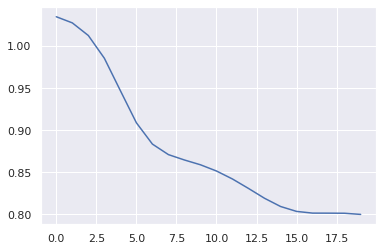

In [25]:
plt.plot(cost_list_1)

## Training Accuracy Plot of Model-1

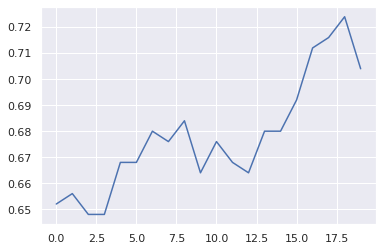

In [27]:
plt.plot(train_acc_list_1)

# Model-2

## Data for model-2
0->covid, 1->Normal, 2->Penumonia

#### Here the labels are modified accordinglly for Model-2

In [28]:
x_train_2 = []
y_train_2 = []

for i in range(len(y_train)):
    if(y_train[i]==0):   ## covid
        x_train_2.append(x_train_final[i])
        y_train_2.append(1)
    elif(y_train[i]==2):  ## pneumonia
        x_train_2.append(x_train_final[i])
        y_train_2.append(-1)


x_train_2 = np.array(x_train_2)
y_train_2 = np.array(y_train_2)

## Binary Classifier Model-2

In [29]:
params_2 = (0.01 * np.random.randn(2, 2, 3), 0.0)
params_2

(tensor([[[ 0.00982229, -0.01051254, -0.00914393],
          [ 0.00723045,  0.02842324,  0.02840841]],
 
         [[ 0.01032002, -0.00327675, -0.00191936],
          [-0.01266729, -0.00914445, -0.00208504]]], requires_grad=True), 0.0)

In [30]:
iters = 20
optimizer_2 = qml.NesterovMomentumOptimizer(stepsize=0.1)

cost_list_2 = []
train_acc_list_2 = []

for iter in range(iters):
    params_2 = optimizer_2.step(lambda v: cost_2(v, x_train_2, y_train_2), params_2)

    cost_list_2.append(cost_2(params_2, x_train_2, y_train_2))
    train_acc_list_2.append(accuracy_2(params_2, x_train_2, y_train_2, iter))

Iter=> 1   train_cost=> 1.2614721878608255   train_acc=> 0.4666666666666667 
Iter=> 2   train_cost=> 1.2355844199126527   train_acc=> 0.5388888888888889 
Iter=> 3   train_cost=> 1.219687970878121   train_acc=> 0.5277777777777778 
Iter=> 4   train_cost=> 1.2143219322766938   train_acc=> 0.5444444444444444 
Iter=> 5   train_cost=> 1.2128913745419498   train_acc=> 0.5555555555555556 
Iter=> 6   train_cost=> 1.2091136338732122   train_acc=> 0.55 
Iter=> 7   train_cost=> 1.2007423257853913   train_acc=> 0.5555555555555556 
Iter=> 8   train_cost=> 1.1889561153269006   train_acc=> 0.5611111111111111 
Iter=> 9   train_cost=> 1.175910452260856   train_acc=> 0.5611111111111111 
Iter=> 10   train_cost=> 1.162933961294422   train_acc=> 0.5444444444444444 
Iter=> 11   train_cost=> 1.1502248304824492   train_acc=> 0.5277777777777778 
Iter=> 12   train_cost=> 1.1374995762124938   train_acc=> 0.5166666666666667 
Iter=> 13   train_cost=> 1.1246758401958146   train_acc=> 0.5166666666666667 
Iter=> 14   

## Cost Plot of Model-2

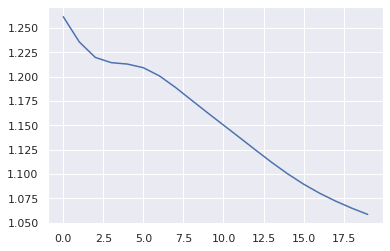

In [31]:
plt.plot(cost_list_2)

## Training Accuracy Plot of Model-2

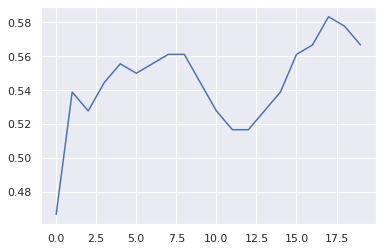

In [32]:
plt.plot(train_acc_list_2)

# Prediction

### While Predicting, we first give input to the Model-1. If it predicts as Normal person, then it is the final prediction assigned to the input. If not, then we give the same input to Model-2 and it finally predicts whether the chest x-ray is Covid10 patient or Viral Pneumonia patient. 

In [33]:
y_pred = []

for i in range(len(x_test_final)):
    tmp = classifier_prediction_1(params_1, x=x_test_final[i])
    if (tmp == 1):  ## Normal person
        y_pred.append(1)
    else:   ## Covid or Pneumonia
        tmp = classifier_prediction_2(params_2, x=x_test_final[i])
        if(tmp == 1):  ## covid
            y_pred.append(0)
        elif(tmp == -1): ## Pneumonia
            y_pred.append(2)

y_pred = np.array(y_pred)

In [34]:
print("Final_Test_Accuracy => ", np.sum(y_pred==y_test)/len(y_test))

Final_Test_Accuracy =>  0.4461538461538462


### We are hopeful to in increment in this accuracy when it will be trained on real computer with larger dataset. 